In [1]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime, timedelta

from cosinorage.dataloaders import DataLoader
from cosinorage.features import WearableFeatures

%load_ext autoreload
%autoreload 2

In [2]:
reload_nhanes = True

In [3]:
if reload_nhanes:
    nhanes_loader = DataLoader(datasource='nhanes', input_path='../data/', person_id=62164)
    nhanes_loader.load_data(verbose=True)
    with open("nhanes_loader.pkl", "wb") as file:
        pickle.dump(nhanes_loader, file)
else:
    with open("nhanes_loader.pkl", "rb") as file:
        nhanes_loader = pickle.load(file)

Found 2 versions of NHANES data


Reading day-level files: 100%|██████████| 2/2 [00:00<00:00, 24.70it/s]


Read 9 day-level records for person 62164


Processing chunks for version H: 883it [01:03, 13.81it/s], ?it/s]
Processing chunks for version G: 782it [00:57, 13.58it/s]1:03, 63.92s/it]
Reading minute-level files: 100%|██████████| 2/2 [02:01<00:00, 60.76s/it]


Read 11529 minute-level records for person 62164


Reading header files: 100%|██████████| 2/2 [00:00<00:00, 113.03it/s]


Merged day- and minute-level data for person 62164
Renamed columns and set timestamp index for person 62164
Calculated ENMO for person 62164
Loaded 10080 minute-level ENMO records from ../data/
Filtered out 0 minute-level ENMO records due to incomplete daily coverage
load_data executed in 121.77 seconds


In [4]:
nhanes_loader.get_enmo_data().head()

,X,Y,Z,wear,sleep,paxpredm,ENMO
TIMESTAMP,,,,,,,
1900-01-02 00:00:00,5.397605e-79,5.397605e-79,5.397605e-79,1,1,2,0.0
1900-01-02 00:01:00,5.397605e-79,5.397605e-79,5.397605e-79,1,1,2,0.0
1900-01-02 00:02:00,5.397605e-79,5.397605e-79,5.397605e-79,1,1,2,0.0
1900-01-02 00:03:00,5.397605e-79,5.397605e-79,5.397605e-79,1,1,2,0.0
1900-01-02 00:04:00,5.397605e-79,5.397605e-79,5.397605e-79,1,1,2,0.0


100%|██████████| 10079/10079 [00:00<00:00, 56177.62it/s]


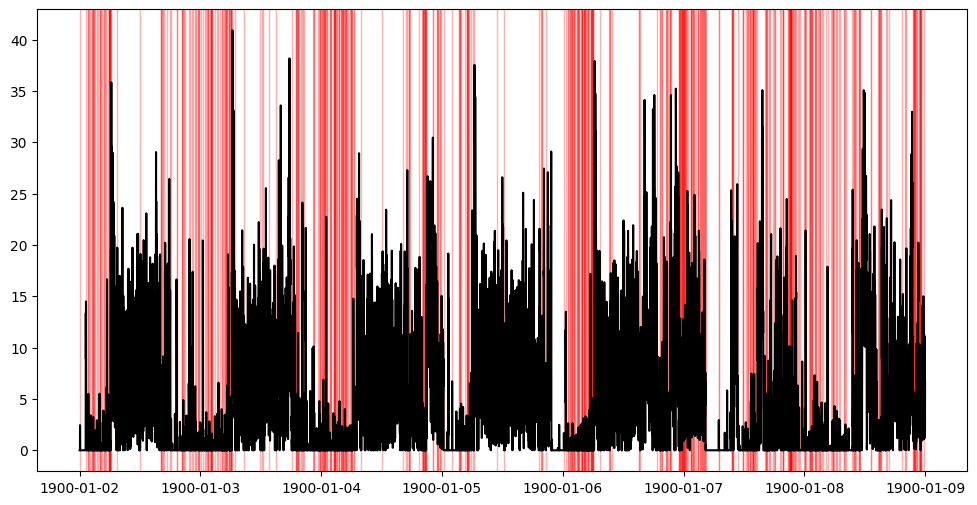

In [5]:
nhanes_loader.plot_enmo()

In [6]:
nhanes_loader.get_enmo_data()['paxpredm'].value_counts()

paxpredm
1    6589
2    2980
4     511
Name: count, dtype: int64

In [7]:
nhanes_loader.enmo_df.describe()
features = WearableFeatures(nhanes_loader)
features.run()
df, dict = features.get_all()


/Users/jacobleooskar/Documents/Education/ETHZ/Curriculum/Semester03/03SemProj/CosinorAge/cosinorage/features/utils/cosinor_analysis.py:60: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  fitted_vals_df = pd.concat([fitted_vals_df, model.fittedvalues], ignore_index=False)


In [8]:
df

,MESOR,amplitude,acrophase,acrophase_time,IV,IS,RA,M10,M10_start,L5,L5_start,SB,LIPA,MVPA,TST,WASO,PTA,SRI
1900-01-02,4.194609,4.593569,3.006855,689.120389,0.553234,0.310854,0.955252,8.365472,6,0.191452,0,10.533333,0.000000,13.466667,905,529.0,0.628472,NaN
1900-01-03,4.803938,4.422045,-2.878984,780.185477,0.519078,0.250183,0.933992,8.939045,17,0.305092,2,9.033333,0.000000,14.966667,974,458.0,0.676389,58.472222
1900-01-04,5.012393,2.489812,-2.482200,871.121566,0.649806,0.319540,0.924919,8.439007,21,0.329160,5,6.433333,0.016667,17.550000,1182,248.0,0.820833,46.388889
1900-01-05,5.484251,4.096234,-2.766205,806.032545,0.575909,0.287222,0.971098,8.646607,6,0.126786,22,7.783333,0.016667,16.200000,1010,430.0,0.701389,58.888889
1900-01-06,6.134147,3.395487,-2.247490,924.913141,0.608270,0.257791,0.930901,10.211573,22,0.365432,2,6.000000,0.016667,17.983333,1235,191.0,0.857639,60.138889
1900-01-07,3.467894,1.231169,-0.977494,1215.974773,0.472333,0.367982,0.985093,6.656131,15,0.049983,5,11.550000,0.066667,12.383333,827,613.0,0.574306,-8.055556
1900-01-08,4.382392,3.788104,-2.085018,962.149062,0.429239,0.260761,0.946060,8.343865,11,0.231270,8,9.366667,0.050000,14.583333,967,470.0,0.671528,24.444444


In [9]:
dict

{'MESOR': np.float64(4.782803509320714),
 'amplitude': np.float64(2.966677925003311),
 'acrophase': np.float64(-2.6101382986735926),
 'acrophase_time': np.float64(841.8003661621841)}

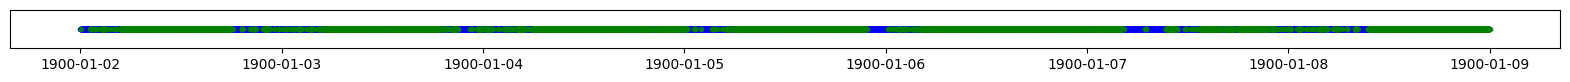

In [10]:
features.plot_sleep_predictions()